# Epigenetic Priming of Endothelial Lineage Before Gastrulation
Sendra et al. 2024

## Prospective clonal analysis with TAT-Cre injection

In [54]:
# Data science and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.viz import plot_connectivity_circle

# Statistics
from scipy.stats import chisquare, ks_2samp
from sklearn.metrics import pairwise_distances

# Other utilities
from datetime import datetime
import os
import math

# Enable inline plotting
%matplotlib inline

#### set default parameters for all the figures for the paper

In [10]:
import matplotlib as mpl

# Set Seaborn style
sns.set_style('ticks')

# Configure matplotlib parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['axes.labelsize']= 13
plt.rcParams['axes.titlesize']= 13
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = (4, 3)  # Adjust the figure size
markersize = 6  # Define a markersize variable for consistency

We microinjected 0,065 pL of TAT–Cre solution as previously described (Sendra et al. 2023) to 158  embryos from Pre–Streak
∼E6.25 to Late Bud ∼7.25 stages in the nascent mesoderm (or the posterior epiblast in
the case of Pre–Streak embryos) and cultured them. After discarding 23 undeveloped
embryos, we detected 19 embryos, each containing a fluorescent cluster in the heart. Of these, one contained both GFP and Tdtomato cells and the rest were monocolour. The use of the two–reporter strategy allowed us to estimate that monocolour clusters in our embryo collection had a 93% chance of being monoclonal.

In [11]:
# paths to data
collection_5U = '../data/prospective_clonal_analysis/prospective_clusters_5U.xlsx'
# output dir
out = './figures_definitive'

# Load data from the cre doses recombination into a pandas dataframe
clusters = pd.read_excel(collection_5U) 

## Summay table of all the clusters in the heart collection

In [12]:
# Select clusters that contain cardiac cells (CM or EC)
cardiac_clusters = clusters[(clusters['EC'] > 0) | (clusters['CM'] > 0)].copy()  # Create a copy of the selected clusters

# As the stages are not in numerical values (i.e. E6.5) we have to create a categorical sorter
stage_sorter = {'PS': 6.25, 'PS-ES': 6.5, 'ES': 6.6, 'MS': 6.75, 'LS-0B': 7.0, 'EB-LB': 7.25, 'LB': 7.5}
cardiac_clusters['numerical_stage'] = cardiac_clusters['stage'].map(stage_sorter)

# Now we sort by the stages
cardiac_clusters = cardiac_clusters.sort_values(by='numerical_stage', ascending=True)


# Define major groups outcomment groups that sum 0 so they dont show blank in the heatmap
major_groups = {
    'CM': ['CM'],
    'EC': ['EC'],
    'EmM': ['JCF', 'Pericardium', 'aSHF', 'pSHF'],
    #'E-Et': ['Dorsal_aortae'],
    'ExM': ['Extraembryonic mesoderm', 'Amnion'],
    #'End': ['Extraembryonic_endoderm', 'Embryonic_endoderm']
}



# Create a summary dataframe adding up the different cell types in major groups
clusters_summary = cardiac_clusters.loc[:, 'cluster_ID':'num_cells'].copy()  # Create a copy of the selected columns

for group_name, group_columns in major_groups.items():
    clusters_summary[group_name] = cardiac_clusters[group_columns].sum(axis=1)



# Assign the categorical data type to the 'stage' column
cardiac_clusters['stage'] = cardiac_clusters['stage'].astype('category')
cardiac_clusters['stage'].cat.set_categories(stage_sorter, ordered=True, inplace=True)

# Now we sort by the stages
cardiac_clusters.sort_values(by='stage', ascending=True, inplace=True)


In [13]:
clusters_summary

,cluster_ID,embryo_ID,embryo_label,stage,region,experiment_ID,culture_time,reporter,num_cells,CM,EC,EmM,ExM
28,29,24,p8,PS,NaN,NaN,60,Tdtomato,55,13.0,27.0,15.0,0.0
26,27,23,p9,PS,NaN,27,60,GFP,51,13.0,21.0,17.0,0.0
25,26,23,p9,PS,NaN,27,60,TdtomatoGFP,55,12.0,29.0,14.0,0.0
22,23,20,placa A p5,PS,2.0,24,40,GFP,36,10.0,9.0,17.0,0.0
21,22,19,Placa A p4,PS,1.0,24,40,GFP,15,15.0,0.0,0.0,0.0
18,19,16,E5,PS,1.0,15,40,Tdtomato,26,9.0,5.0,12.0,0.0
27,28,24,p8,PS,NaN,NaN,60,GFP,40,18.0,0.0,22.0,0.0
17,18,15,E4,PS-ES,1.0,15,40,Tdtomato,25,6.0,8.0,11.0,0.0
14,15,13,E11,ES,2.0,12,40,GFP,7,3.0,0.0,4.0,0.0
12,13,11,E3,ES,1.0,12,40,Tdtomato,23,6.0,0.0,17.0,0.0


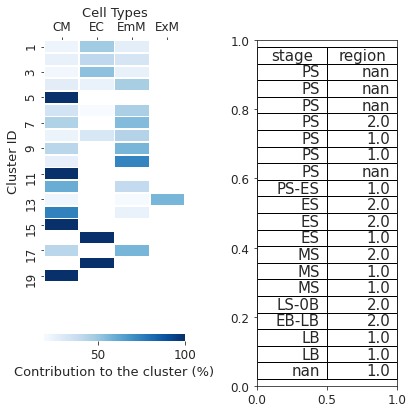

In [14]:
# Reset index to match cluster_ID
clusters_summary.reset_index(drop=True, inplace=True)
clusters_summary.index += 1

# Select columns containing counts
clusters_cont_num = clusters_summary[['CM', 'EC', 'EmM', 'ExM']].copy()
# Normalize to percentages
clusters_cont_norm = clusters_cont_num.div(clusters_cont_num.sum(axis=1), axis=0) * 100

# Replace 0 values with NaN
clusters_cont_num.replace(0, np.nan, inplace=True)
mask = clusters_cont_num.isnull()

# Create subplots with 1 row and 2 columns (for heatmap and table)
fig, axs = plt.subplots(1, 2, figsize=(6,6))

# Heatmap plot on the left subplot (axs[0])
ax = sns.heatmap(clusters_cont_norm, mask=mask, fmt='g', linewidth=0.8,
                 cmap='Blues', cbar_kws={'label': 'Contribution to the cluster (%)', 'orientation': 'horizontal'}, ax=axs[0])
ax.set_xlabel('Cell Types')
ax.set_ylabel('Cluster ID')
plt.yticks(rotation=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Table plot on the right subplot (axs[1])
df = cardiac_clusters[['stage', 'region']]
table = axs[1].table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.scale(1, 1.5)

# Save the figure
plt.tight_layout()

path = 'summary_table_prospective'
file_path = os.path.join(out, path + '.svg')
plt.savefig(file_path, dpi=300)



In [49]:
# Reset index so the numbers correspond to a cronological order. keep the old index to identify the raw data
clusters_summary = clusters_summary.reset_index(drop = True)

# give the new index a meaningful name
clusters_summary.index = clusters_summary.index.set_names(['cluster_ID'])

clusters_summary.index += 1

# Save a copy in excel for the supplementary files
clusters_summary.to_excel(os.path.join(out, 'supplementary_data_clusters_prospective.xlsx'))

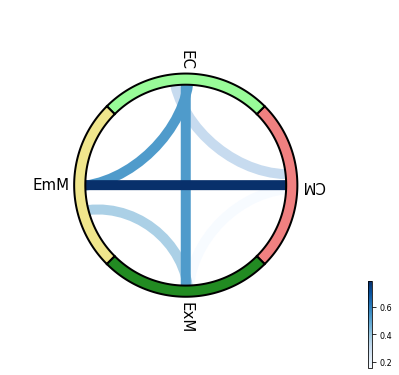

In [56]:
# Select and copy relevant columns for plotting
columns_to_plot = ['CM', 'EC', 'EmM', 'ExM']
clusters_summary_num = clusters_summary[columns_to_plot].copy()

# Convert the clusters count dataframe to a binary. If there are cells of that type then 1 else 0. 
clusters_summary_num[clusters_summary_num > 0] = 1

# Calculate the Jaccard similarity matrix for the entire DataFrame
# This is the coapearence frequency of two cell types in the same cluster
matrix = 1 - pairwise_distances(clusters_summary_num.T, metric="hamming")

# 'matrix' now contains the Jaccard similarity values

# Names of the nodes of the circle
names = clusters_summary_num.columns.tolist()

N = len(names)  # Number of nodes (cell types) to connect in the chord diagram
node_names = names  # Names of the cell types to connect

colors = ['lightcoral', 'palegreen', 'khaki', 'forestgreen']

fig, axes = plot_connectivity_circle(matrix, node_names, node_colors=colors, fontsize_names=15,
                                             colormap='Blues', facecolor='white', textcolor='black',
                                             linewidth=10)

fig.savefig(os.path.join(out, 'chord_cell_type_coapearance_jaccard_prospective.svg'))